In [91]:
import lsst.afw.cameraGeom as cameraGeom
import lsst.afw.geom as afwGeom
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import yaml
import lsst.geom
import numpy as np
from lsst.obs.base.yamlCamera import makeAmplifierList
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection 

In [92]:
%matplotlib widget

In [93]:
butler = Butler('embargo', collections='LSSTCam/defaults')

In [94]:
camera = butler.get('camera', instrument='LSSTCam')

### First try to replicate obs_lsst camera from obs_lsst/policy

In [98]:
cameraFile = '/home/c/csaunder/u/clones/obs_lsst/policy/lsstCam.yaml'
with open(cameraFile) as f:
    cameraParams = yaml.load(f, Loader=yaml.CLoader)

In [99]:
cameraName = cameraParams['name']
plateScale = lsst.geom.Angle(cameraParams["plateScale"], lsst.geom.arcseconds)
nativeSys = cameraGeom.CameraSys(cameraParams["transforms"].pop("nativeSys"))

In [100]:
# Make transform dict:
transforms = {}
# There's only one in cameraParams['transforms']
radialCoeffs = np.array(cameraParams['transforms']['FieldAngle']['coeffs'])
radialCoeffs *= plateScale.asRadians()
transform = afwGeom.makeRadialTransform(radialCoeffs)
transforms[cameraGeom.CameraSys('FieldAngle')] = transform

In [155]:
ccdParams = cameraParams['CCDs']

In [103]:
detectorConfigs = []
for name, ccdParam in ccdParams.items():
    detectorConfig = cameraGeom.DetectorConfig()
    detectorConfigs.append(detectorConfig)
    detectorConfig.name = name
    detectorConfig.id = ccdParam['id']
    detectorConfig.serial = ccdParam['serial']
    detectorConfig.detectorType = ccdParam["detectorType"]
    detectorConfig.bbox_x0, detectorConfig.bbox_y0 = ccdParam["bbox"][0]
    detectorConfig.bbox_x1, detectorConfig.bbox_y1 = ccdParam["bbox"][1]
    detectorConfig.pixelSize_x, detectorConfig.pixelSize_y = ccdParam["pixelSize"]
    detectorConfig.transformDict.nativeSys = ccdParam["transformDict"]["nativeSys"]
    detectorConfig.transformDict.transforms = None 
    detectorConfig.refpos_x, detectorConfig.refpos_y = ccdParam["refpos"]
    detectorConfig.offset_x, detectorConfig.offset_y, detectorConfig.offset_z = ccdParam["offset"]
    detectorConfig.transposeDetector = ccdParam["transposeDetector"]
    detectorConfig.pitchDeg = ccdParam["pitch"]
    detectorConfig.yawDeg = ccdParam["yaw"]
    detectorConfig.rollDeg = ccdParam["roll"]


In [156]:
# For the amplifiers, we are just going to use what is in the obs_lsst package. This won't be used below anyway.
amplifierDict = {}
for ccdName, ccdValues in ccdParams.items():
    amplifierDict[ccdName] = makeAmplifierList(ccdValues)

In [105]:
# Construct the camera:
focalPlaneToField = transforms[cameraGeom.FIELD_ANGLE]
cameraBuilder = cameraGeom.Camera.Builder(cameraName)
cameraBuilder.setPupilFactoryClass(cameraGeom.pupil.PupilFactory)

for toSys, transform in transforms.items():
    cameraBuilder.setTransformFromFocalPlaneTo(toSys, transform)

for detectorConfig in detectorConfigs:
    cameraGeom.addDetectorBuilderFromConfig(cameraBuilder, detectorConfig, amplifierDict[detectorConfig.name],
                                            focalPlaneToField)

newCamera = cameraBuilder.finish()

## Test the camera transforms:

The check below shows that the camera we built is identical to the LSSTCam camera in the butler (as it should be):

In [157]:
for detector in camera:
    detBBox = detector.getBBox()
    
    corners = np.array([(c.getX(), c.getY()) for c in detector.getCorners(cameraGeom.FOCAL_PLANE)])
    newDet = newCamera[detector.getId()]
    newCorners = np.array([(c.getX(), c.getY()) for c in newDet.getCorners(cameraGeom.FOCAL_PLANE)])
    assert (corners == newCorners).all()


## Now make a new camera with new offsets and rotation:

To add an arbitrary distortion between the detectors and the focal plane, you would add that in the line below that is currently `detectorConfig.transformDict.transforms = None`. For an arbitrary transform between the focal plane and field angle, that would go in the `transforms` dictionary above, which is currently set with a radial transform.

In [158]:
fitParams = np.loadtxt('/home/c/csaunder/stack_projects/LSSTCam_camModel/All_Rafts_Design_and_Measured_Offsets_2025042500591.txt',
                      dtype='str')

In [108]:
newXOffset = np.array([float(fp.strip(',')) for fp in fitParams[:,3]])
newYOffset = np.array([float(fp.strip(',')) for fp in fitParams[:,4]])
newRot = np.array(fitParams[:,5]).astype(float)

In [109]:
fitDetectorConfigs = []
for i, name in enumerate(fitParams[:,0]):
    ccdParam = ccdParams[name]
    detectorConfig = cameraGeom.DetectorConfig()
    fitDetectorConfigs.append(detectorConfig)
    detectorConfig.name = name
    detectorConfig.id = ccdParam['id']
    detectorConfig.serial = ccdParam['serial']
    detectorConfig.detectorType = ccdParam["detectorType"]
    detectorConfig.bbox_x0, detectorConfig.bbox_y0 = ccdParam["bbox"][0]
    detectorConfig.bbox_x1, detectorConfig.bbox_y1 = ccdParam["bbox"][1]
    detectorConfig.pixelSize_x, detectorConfig.pixelSize_y = ccdParam["pixelSize"]
    detectorConfig.transformDict.nativeSys = ccdParam["transformDict"]["nativeSys"]
    detectorConfig.transformDict.transforms = None 
    detectorConfig.refpos_x, detectorConfig.refpos_y = ccdParam["refpos"]
    detectorConfig.offset_x = newXOffset[i]
    detectorConfig.offset_y = newYOffset[i]
    detectorConfig.offset_z = 0
    detectorConfig.transposeDetector = ccdParam["transposeDetector"]
    detectorConfig.pitchDeg = ccdParam["pitch"]
    detectorConfig.yawDeg = newRot[i]
    detectorConfig.rollDeg = ccdParam["roll"]

In [110]:
# Construct the camera:
focalPlaneToField = transforms[cameraGeom.FIELD_ANGLE]
cameraBuilder = cameraGeom.Camera.Builder(cameraName)
cameraBuilder.setPupilFactoryClass(cameraGeom.pupil.PupilFactory)

for toSys, transform in transforms.items():
    cameraBuilder.setTransformFromFocalPlaneTo(toSys, transform)

for detectorConfig in fitDetectorConfigs:
    cameraGeom.addDetectorBuilderFromConfig(cameraBuilder, detectorConfig, amplifierDict[detectorConfig.name],
                                            focalPlaneToField)

fitCamera = cameraBuilder.finish()

In [124]:
# Inspect the new camera:
patches = []
fitPatches = []
centerDiffs = []
for fitDet in fitCamera:
    origDet = camera[fitDet.getId()]
    corners = np.array([(c.getX(), c.getY()) for c in origDet.getCorners(cameraGeom.FOCAL_PLANE)])
    patches.append(Polygon(corners, closed=True))
    origCenter = origDet.getCenter(cameraGeom.FOCAL_PLANE)

    fitCorners = np.array([(c.getX(), c.getY()) for c in fitDet.getCorners(cameraGeom.FOCAL_PLANE)])
    fitPatches.append(Polygon(fitCorners, closed=True))
    fitCenter = fitDet.getCenter(cameraGeom.FOCAL_PLANE)

    dX = fitCenter.x - origCenter.x
    dY = fitCenter.y - origCenter.y
    centerDiffs.append([origCenter.x, origCenter.y, dX, dY])
centerDiffs = np.array(centerDiffs)

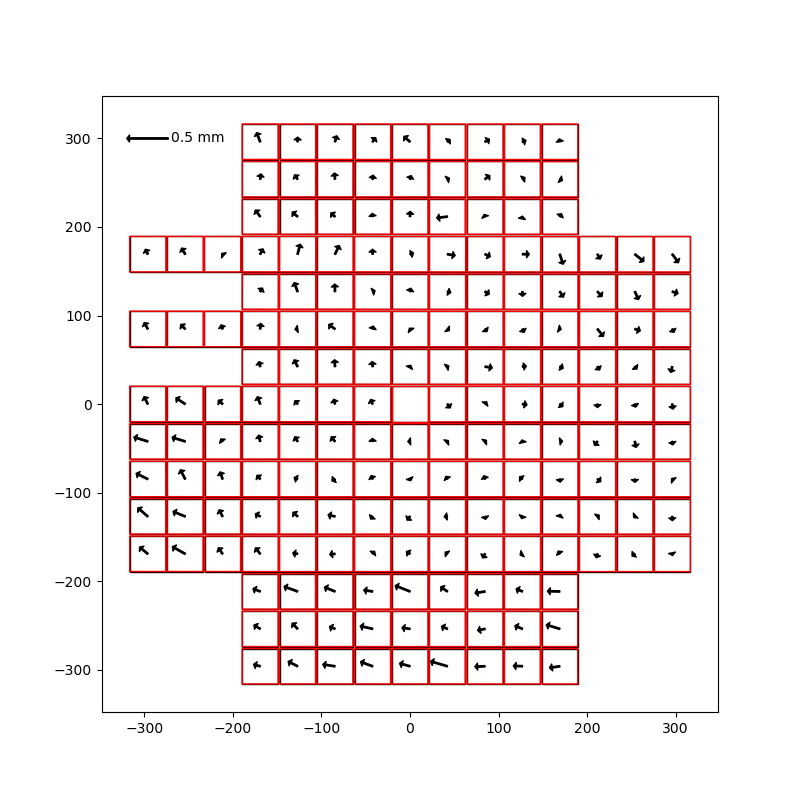

In [154]:
# Plot the design and fit detector positions (difference is too small to see unless you zoom in)
# and the shift in the detector center (multiplied by 100 to make visible)

fig, ax = plt.subplots(figsize=(8, 8))
patchCollection = PatchCollection(patches, edgecolor='k', facecolors='None', linewidth=1)
ax.add_collection(patchCollection)
fitPatchCollection = PatchCollection(fitPatches, edgecolor='r', facecolors='None', linewidth=1)
ax.add_collection(fitPatchCollection)
for diff in centerDiffs:
    xy = (diff[0] + 100 * diff[2], diff[1] + 100 * diff[3])
    xyt = (diff[0], diff[1])
    ax.annotate("", xy, xytext=xyt,
               arrowprops=dict(facecolor='black', headlength=2, headwidth=5, width=1, shrink=0),
               verticalalignment='center', horizontalalignment='center')

ax.annotate("0.5 mm", (-320, 300), xytext=(-270, 300),
            arrowprops=dict(facecolor='black', headlength=2, headwidth=5, width=1, shrink=0),
            verticalalignment='center')
ax.autoscale_view()
ax.set_aspect('equal')
